# RSIベースのトレードルール

input:現在の日付、所持金、取り扱いデータ（dataframe）<br>
output:更新された所持金<br>

In [155]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
from utils.RSI import output_rsi_time_series

In [156]:
#パラメータ
current_day = '2021-06-07'
posses = {'JPY':10000,'USD':0}
jpy_usd = pd.read_csv('../temp_data/jpy_usd.csv')

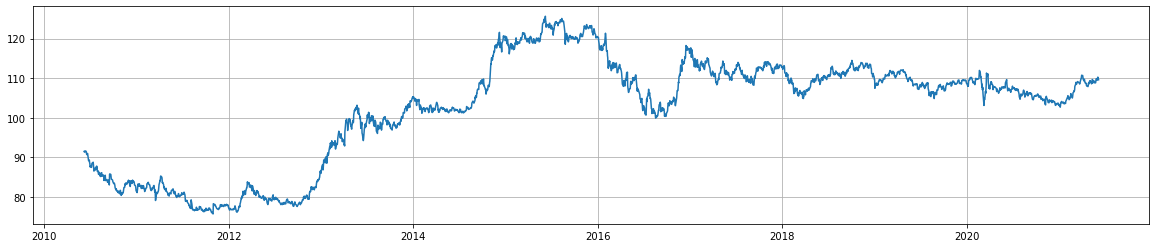

In [157]:
jpy_usd.index = pd.to_datetime(jpy_usd['Date'])
del jpy_usd['Date']
next_day = jpy_usd[current_day:].index[0]
jpy_usd = jpy_usd[:current_day]
plt.figure(figsize=(20,4))
plt.plot(jpy_usd['Close'])
plt.grid()
plt.show()

In [158]:
jpy_usd

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-07,91.570000,92.064003,90.989998,91.515999,91.515999,0
2010-06-08,91.489998,91.906998,90.885002,91.410004,91.410004,0
2010-06-09,91.410004,91.654999,91.040001,91.364998,91.364998,0
2010-06-10,91.320999,91.441002,90.855003,91.308998,91.308998,0
2010-06-11,91.331001,91.755997,91.262001,91.620003,91.620003,0
...,...,...,...,...,...,...
2021-06-01,109.477997,109.693001,109.333000,109.492996,109.492996,0
2021-06-02,109.483002,109.883003,109.483002,109.492996,109.492996,0
2021-06-03,109.593002,110.309998,109.583000,109.595001,109.595001,0


In [159]:
jpy_usd = jpy_usd.drop(['Adj Close','Volume','High','Low','Open'],axis=1)

In [160]:
#過去約3年で最も利益率が高いRSI値を使い、直近半年で一応確認して最終的に使う

about_three_years = 750
about_half_years = 110

train = jpy_usd.iloc[-about_three_years-about_half_years:-about_half_years,:]
test = jpy_usd.iloc[-about_half_years:,:]

In [161]:
import warnings
warnings.simplefilter('ignore')

max_sharp = 0

for param in [9,10,11,12,13,14,15,16,17,18]:

    print('param:',param)
    #RSIの計算
    train['RSI_'+str(param)] = output_rsi_time_series(train['Close'],param=param)
    train['buy_sell_flag'] = 0
    train.loc[train['RSI_'+str(param)]>=70,'buy_sell_flag'] = 'sell'
    train.loc[train['RSI_'+str(param)]<=30,'buy_sell_flag'] = 'buy'
    
    #バックテスト
    rec = []
    posses_ = {'JPY':10000,'USD':0}
    for i in range(len(train)):
        if train['buy_sell_flag'][i]=='buy':
            posses_['JPY'] += posses_['USD']*0.5*train.iloc[i,0]
            posses_['USD'] = posses_['USD']*0.5
            rec.append(posses_['JPY']+posses_['USD']*train.iloc[i,0])

        elif train['buy_sell_flag'][i]=='sell':
            posses_['USD'] += posses_['JPY']*0.5/train.iloc[i,0]
            posses_['JPY'] = posses_['JPY']*0.5
            rec.append(posses_['JPY']+posses_['USD']*train.iloc[i,0])
    
    #シャープレシオ計算
    rec = np.array(rec)
    risk = rec.std()/10000
    ret = (rec.mean()-10000)/10000
    sharp = ret/risk
    print('シャープレシオ:',sharp)
    
    print('最終収支:',rec[-1])
    
    #最高記録
    if max_sharp < sharp:
        max_sharp = sharp
        max_param = param

param: 9
シャープレシオ: -0.789623038536257
最終収支: 8972.00297870176
param: 10
シャープレシオ: -1.2894864525354726
最終収支: 9320.456147513336
param: 11
シャープレシオ: 0.06951566172138764
最終収支: 9781.197603296147
param: 12
シャープレシオ: 0.4040018945589417
最終収支: 9822.424189163932
param: 13
シャープレシオ: 2.309059859732192
最終収支: 10096.486003945056
param: 14
シャープレシオ: 1.651150246988115
最終収支: 10033.318409815713
param: 15
シャープレシオ: -0.3679006880828016
最終収支: 9831.689616541666
param: 16
シャープレシオ: -0.24797833261717675
最終収支: 9844.87238297873
param: 17
シャープレシオ: -0.7815823343514305
最終収支: 9795.768097815593
param: 18
シャープレシオ: 0.2707021419228458
最終収支: 9950.726309765289


In [162]:
print(max_sharp,max_param)

2.309059859732192 13


In [163]:
import warnings
warnings.simplefilter('ignore')

print('param:',max_param)
#RSIの計算
test['RSI_'+str(max_param)] = output_rsi_time_series(test['Close'],param=max_param)
test['buy_sell_flag'] = 0
test.loc[test['RSI_'+str(max_param)]>=70,'buy_sell_flag'] = 'sell'
test.loc[test['RSI_'+str(max_param)]<=30,'buy_sell_flag'] = 'buy'

#バックテスト
rec = []
posses_ = {'JPY':10000,'USD':0}
for i in range(len(test)):
    if test['buy_sell_flag'][i]=='buy':
        posses_['JPY'] += posses_['USD']*0.5*test.iloc[i,0]
        posses_['USD'] = posses_['USD']*0.5
        rec.append(posses_['JPY']+posses_['USD']*test.iloc[i,0])

    elif test['buy_sell_flag'][i]=='sell':
        posses_['USD'] += posses_['JPY']*0.5/test.iloc[i,0]
        posses_['JPY'] = posses_['JPY']*0.5
        rec.append(posses_['JPY']+posses_['USD']*test.iloc[i,0])

#シャープレシオ計算
rec = np.array(rec)
risk = rec.std()/10000
ret = (rec.mean()-10000)/10000
sharp = ret/risk
print('シャープレシオ:',sharp)

print('最終収支:',rec[-1])

param: 13
シャープレシオ: 1.4429461901165397
最終収支: 10242.122174771015


In [164]:
jpy_usd['RSI_'+str(max_param)] = output_rsi_time_series(jpy_usd['Close'],param=max_param)
jpy_usd

,Close,RSI_13
Date,,
2010-06-07,91.515999,NaN
2010-06-08,91.410004,NaN
2010-06-09,91.364998,NaN
2010-06-10,91.308998,NaN
2010-06-11,91.620003,NaN
...,...,...
2021-06-01,109.492996,59.062604
2021-06-02,109.492996,57.979161
2021-06-03,109.595001,52.896454


In [167]:
last_rsi = jpy_usd['RSI_'+str(max_param)][-1]

if last_rsi<=30:
    posses['JPY'] += posses['USD']*0.5*jpy_usd.iloc[i,0]
    posses['USD'] = posses['USD']*0.5

elif last_rsi>=70:
    posses['USD'] += posses['JPY']*0.5/jpy_usd.iloc[i,0]
    posses['JPY'] = posses['JPY']*0.5

51.2226004116215